Device: cuda
n_features: 10 | train/val/test: 5938 659 1650
train end date: 2018-01-23 00:00:00 | test start date: 2018-01-24 00:00:00
Epoch 10/100 | VAL=0.001807
Epoch 20/100 | VAL=0.000955
Epoch 30/100 | VAL=0.000795
Epoch 40/100 | VAL=0.000494
Epoch 50/100 | VAL=0.000544
Epoch 60/100 | VAL=0.000535
Early stop @ 61 | best VAL=0.000357
[TEST one-step] RMSE: 0.1007 | MAE: 0.0878 | R2: 0.9905


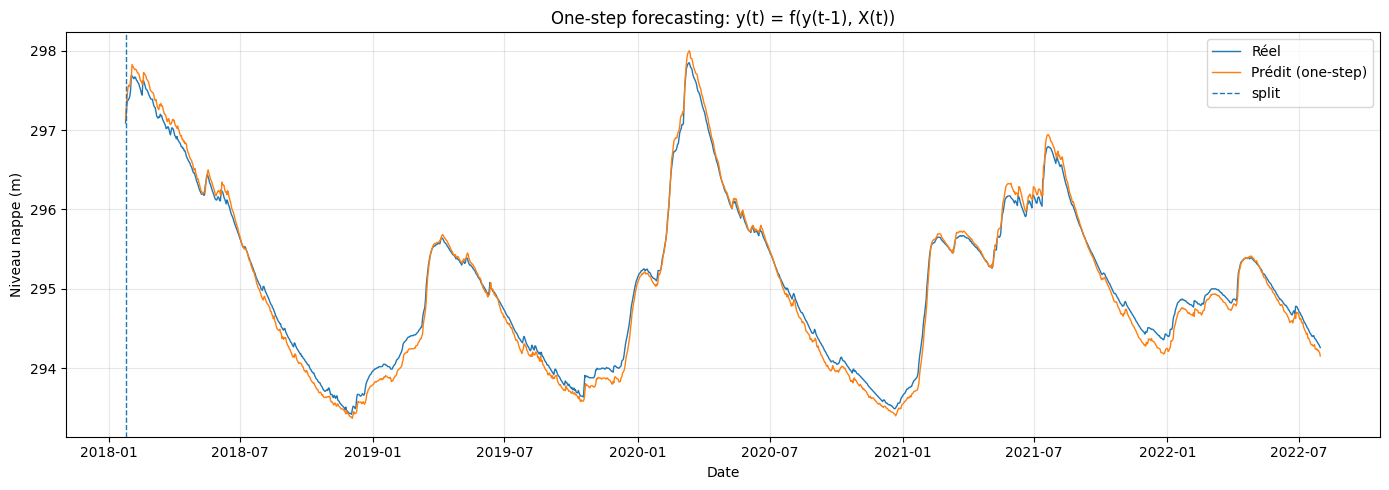

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# =========================
# Config
# =========================
PIEZO_FILE = "dataset/time_series/piezos/BSS001CVLZ.csv"
FORCAGE_FILE = "dataset/time_series/forçages/A146020302.txt"

TRAIN_RATIO_RAW = 0.8
VAL_RATIO_IN_TRAIN = 0.1

# One-step setup
SEQUENCE_LENGTH = 1     # on donne UNE "ligne" par jour (pas 30 jours)
FORECAST_HORIZON = 1    # on prédit y(t) uniquement

# Transformer params (tu peux réduire, mais je garde proche de ton code)
D_MODEL = 64
N_HEAD = 4
NUM_LAYERS = 2
DIM_FF = 128
DROPOUT = 0.2

LEARNING_RATE = 1e-3
EPOCHS = 100
BATCH_SIZE = 128
WEIGHT_DECAY = 1e-4
GRAD_CLIP = 1.0
PATIENCE_EARLYSTOP = 15

base_features = ['Ptot', 'Temp', 'E_PM', 'Humi', 'Vent', 'IHGR', 'SWI']
target = 'niveau_nappe_eau'

USE_DOY_ENCODING = True  # sin/cos day-of-year

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# =========================
# Load & preprocess
# =========================
df_piezo = pd.read_csv(PIEZO_FILE)
df_piezo['date'] = pd.to_datetime(df_piezo['date_mesure'])
df_piezo = df_piezo[['date', target]].set_index('date')

df_forcage = pd.read_csv(FORCAGE_FILE, sep=';', comment='#', skipinitialspace=True)
df_forcage.columns = df_forcage.columns.str.strip()
df_forcage['date'] = pd.to_datetime(df_forcage['Date'], format='%Y%m%d')
df_forcage = df_forcage.set_index('date')[base_features]

df = df_piezo.join(df_forcage, how='inner')
df = df[df.index >= '2000-01-01']
df = df.resample('D').mean().interpolate(limit_direction='both')
df = df.replace(-99, np.nan).interpolate(limit_direction='both').dropna()

# y_prev = niveau de la veille (ce que tu veux passer au modèle)
df["y_prev"] = df[target].shift(1)

features = list(base_features) + ["y_prev"]

if USE_DOY_ENCODING:
    doy = df.index.dayofyear.values.astype(np.float32)
    df["doy_sin"] = np.sin(2 * np.pi * doy / 365.25)
    df["doy_cos"] = np.cos(2 * np.pi * doy / 365.25)
    features += ["doy_sin", "doy_cos"]

df = df.dropna()

# =========================
# Dataset one-step: X(t) = [exog(t), y_prev(t), doy(t)] -> y(t)
# =========================
X_raw = df[features].values.astype(np.float32)          # (N, nfeat)
y_raw = df[[target]].values.astype(np.float32)          # (N, 1)

split_raw = int(len(df) * TRAIN_RATIO_RAW)
split_raw = max(split_raw, 10)  # sécurité

# Scalers TRAIN only (no leakage)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
scaler_X.fit(X_raw[:split_raw])
scaler_y.fit(y_raw[:split_raw])

X_scaled = scaler_X.transform(X_raw).astype(np.float32)
y_scaled = scaler_y.transform(y_raw).astype(np.float32)

# On transforme en "séquences" de longueur 1 pour garder ton Transformer inchangé
# X_seq: (N, 1, nfeat) ; y_seq: (N, 1)
X_seq = X_scaled.reshape(-1, 1, X_scaled.shape[1])
y_seq = y_scaled.reshape(-1, 1)  # (N,1)

# Split chrono en train/test
X_train_full, y_train_full = X_seq[:split_raw], y_seq[:split_raw]
X_test, y_test = X_seq[split_raw:], y_seq[split_raw:]

# Val = fin du train
val_size = max(1, int(len(X_train_full) * VAL_RATIO_IN_TRAIN))
X_train, y_train = X_train_full[:-val_size], y_train_full[:-val_size]
X_val, y_val     = X_train_full[-val_size:], y_train_full[-val_size:]

# =========================
# Model
# =========================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=32):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe.unsqueeze(0))

    def forward(self, x):
        return self.dropout(x + self.pe[:, :x.size(1), :])

class TransformerOneStep(nn.Module):
    def __init__(self, input_size, d_model, n_head, num_layers, dim_ff, dropout=0.2):
        super().__init__()
        self.input_proj = nn.Linear(input_size, d_model)
        self.pos_enc = PositionalEncoding(d_model, dropout=dropout, max_len=32)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_head,
            dim_feedforward=dim_ff,
            dropout=dropout,
            batch_first=True,
            activation="gelu",
            norm_first=True,
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)

        # sortie 1 valeur : y(t)
        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, 1)
        )

    def forward(self, x):
        # x: (batch, 1, nfeat)
        z = self.encoder(self.pos_enc(self.input_proj(x)))
        last = z[:, -1, :]
        return self.head(last)  # (batch, 1)

model = TransformerOneStep(
    input_size=len(features),
    d_model=D_MODEL,
    n_head=N_HEAD,
    num_layers=NUM_LAYERS,
    dim_ff=DIM_FF,
    dropout=DROPOUT
).to(device)

# =========================
# Train
# =========================
X_train_t = torch.from_numpy(X_train).to(device)
y_train_t = torch.from_numpy(y_train).to(device)
X_val_t   = torch.from_numpy(X_val).to(device)
y_val_t   = torch.from_numpy(y_val).to(device)
X_test_t  = torch.from_numpy(X_test).to(device)
y_test_t  = torch.from_numpy(y_test).to(device)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=BATCH_SIZE, shuffle=True)

crit = nn.MSELoss()
opt = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=10, factor=0.5)

best_val = float("inf")
bad = 0

print("n_features:", len(features), "| train/val/test:", len(X_train), len(X_val), len(X_test))
print("train end date:", df.index[split_raw-1], "| test start date:", df.index[split_raw])

for epoch in range(EPOCHS):
    model.train()
    for xb, yb in train_loader:
        opt.zero_grad(set_to_none=True)
        pred = model(xb)
        loss = crit(pred, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        opt.step()

    model.eval()
    with torch.no_grad():
        val_loss = crit(model(X_val_t), y_val_t).item()

    sched.step(val_loss)

    if val_loss < best_val - 1e-9:
        best_val = val_loss
        bad = 0
        torch.save(model.state_dict(), "best_tf_onestep.pth")
    else:
        bad += 1

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} | VAL={val_loss:.6f}")

    if bad >= PATIENCE_EARLYSTOP:
        print(f"Early stop @ {epoch+1} | best VAL={best_val:.6f}")
        break

model.load_state_dict(torch.load("best_tf_onestep.pth", map_location=device))

# =========================
# Evaluation one-step on TEST
# =========================
model.eval()
with torch.no_grad():
    pred_test_s = model(X_test_t).cpu().numpy()  # scaled (N,1)

pred_test = scaler_y.inverse_transform(pred_test_s).flatten()
true_test = y_raw[split_raw:].flatten()

rmse = np.sqrt(mean_squared_error(true_test, pred_test))
mae  = mean_absolute_error(true_test, pred_test)
r2   = r2_score(true_test, pred_test)
print(f"[TEST one-step] RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")

# =========================
# Inference: prédire UN jour
# Tu passes: y_prev (réel) + forçages du jour t
# =========================
def predict_one_day(y_prev: float, x_today: dict, date=None) -> float:
    """
    x_today doit contenir les clés base_features: Ptot, Temp, E_PM, Humi, Vent, IHGR, SWI
    y_prev = niveau nappe du jour précédent (réel)
    date (optionnel) = "YYYY-MM-DD" ou Timestamp pour calculer doy
    """
    if USE_DOY_ENCODING and date is not None:
        d = pd.to_datetime(date)
        doy = float(d.dayofyear)
        doy_sin = float(np.sin(2*np.pi*doy/365.25))
        doy_cos = float(np.cos(2*np.pi*doy/365.25))
    elif USE_DOY_ENCODING:
        doy_sin, doy_cos = 0.0, 0.0

    row = [float(x_today[k]) for k in base_features] + [float(y_prev)]
    if USE_DOY_ENCODING:
        row += [doy_sin, doy_cos]

    row = np.array(row, dtype=np.float32).reshape(1, -1)        # (1,nfeat)
    row_s = scaler_X.transform(row).astype(np.float32)          # scaled
    x = torch.from_numpy(row_s).reshape(1, 1, -1).to(device)    # (1,1,nfeat)

    model.eval()
    with torch.no_grad():
        y_s = model(x).cpu().numpy()                            # (1,1) scaled

    y_hat = scaler_y.inverse_transform(y_s)[0, 0]
    return float(y_hat)

# Plot (one-step)
plt.figure(figsize=(14, 5))
plt.plot(df.index[split_raw:], true_test, linewidth=1, label="Réel")
plt.plot(df.index[split_raw:], pred_test, linewidth=1, label="Prédit (one-step)")
plt.axvline(df.index[split_raw], linestyle="--", linewidth=1, label="split")
plt.xlabel("Date")
plt.ylabel("Niveau nappe (m)")
plt.title("One-step forecasting: y(t) = f(y(t-1), X(t))")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


[ROLLING AUTONOME one-step] RMSE: 1.5542 | MAE: 1.3271 | R2: -1.2597


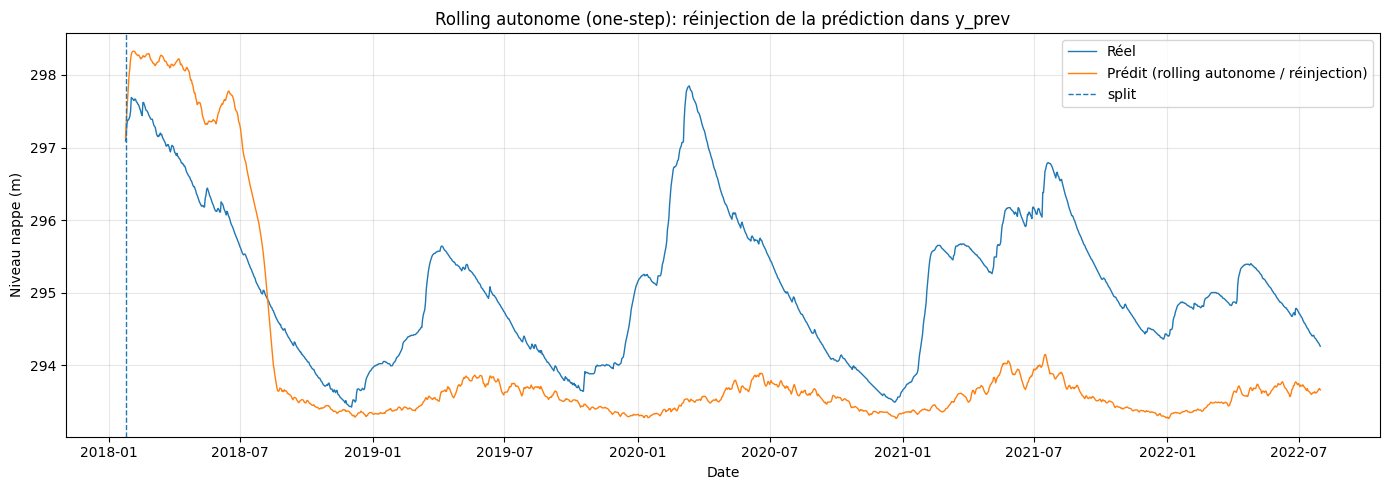

In [17]:
# =========================
# Test rolling AUTONOME (réinjection de y_prev = y_hat)
# =========================

# On va prédire toute la zone TEST (à partir de split_raw)
# en réinjectant la prédiction comme y_prev pour le jour suivant.

model.eval()

# dates test
test_dates = df.index[split_raw:]

# vrai y sur test (pour comparer)
y_true_test = df[target].iloc[split_raw:].values.astype(np.float32)

# buffer prédictions
y_pred_roll = np.zeros(len(test_dates), dtype=np.float32)

# initialisation : y_prev réel = dernier jour de train
y_prev = float(df[target].iloc[split_raw - 1])

for i, d in enumerate(test_dates):
    # forçages du jour d (connus)
    x_today = {k: float(df[k].loc[d]) for k in base_features}

    # prédiction du jour
    y_hat = predict_one_day(y_prev=y_prev, x_today=x_today, date=d)

    y_pred_roll[i] = y_hat

    # réinjection pour le jour suivant
    y_prev = y_hat


# =========================
# Metrics rolling autonome
# =========================
rmse_roll = np.sqrt(mean_squared_error(y_true_test, y_pred_roll))
mae_roll  = mean_absolute_error(y_true_test, y_pred_roll)
r2_roll   = r2_score(y_true_test, y_pred_roll)

print(f"[ROLLING AUTONOME one-step] RMSE: {rmse_roll:.4f} | MAE: {mae_roll:.4f} | R2: {r2_roll:.4f}")


# =========================
# Plot
# =========================
plt.figure(figsize=(14, 5))
plt.plot(test_dates, y_true_test, linewidth=1, label="Réel")
plt.plot(test_dates, y_pred_roll, linewidth=1, label="Prédit (rolling autonome / réinjection)")
plt.axvline(df.index[split_raw], linestyle="--", linewidth=1, label="split")
plt.xlabel("Date")
plt.ylabel("Niveau nappe (m)")
plt.title("Rolling autonome (one-step): réinjection de la prédiction dans y_prev")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
